In [1]:
from load_dataset import *
import matplotlib.pyplot as plt
from scenarios import *

In [2]:
print("="*80)
print("EXEMPLES D'UTILISATION - 4 SCÉNARIOS D'APPRENTISSAGE")
print("="*80)

# Initialiser le loader
loader = MLDatasetLoader('../DATASET/dataset/PAZTSX_CRYO_ML.hdf5')

# 1. Afficher les statistiques
print("\n Statistiques du dataset:")
stats = loader.get_statistics_summary()
print(f"  Classes: {loader.classes}")
print(f"  Satellites: {loader.satellites}")
print(f"  Nombre total de groupes: {loader.n_groups}")

EXEMPLES D'UTILISATION - 4 SCÉNARIOS D'APPRENTISSAGE

 Statistiques du dataset:
  Classes: ['ACC', 'PLA', 'ROC', 'HAG', 'STUDY', 'ABL', 'ICA', 'LAC', 'FOR']
  Satellites: ['TerraSAR-X', 'TanDEM-X', 'PAZ']
  Nombre total de groupes: 280


In [15]:
# ==========================================================================
# SCÉNARIO 1: Classification Temporelle Stacking
# ==========================================================================

scenario1_data = scenario_1_temporal_stacking_classification(
    loader=loader,
    window_size=8,
    max_mask_value=1,
    max_mask_percentage=10.0,
    min_valid_percentage=100.0,  # Changed from 100.0 to 50.0
    orbit='ASC',
    start_date='20200101',
    end_date='20201231',
    scale_type='amplitude',
    skip_optim_offset=True,
)

print("\nScenario 1 terminé:")
print(f"  X.shape: {scenario1_data['X'].shape}")
print(f"  y.shape: {scenario1_data['y'].shape}")
print(f"  groups.shape: {scenario1_data['groups'].shape}")
print(f"  Labels uniques: {np.unique(scenario1_data['y'])}")
print(f"  Classes: {scenario1_data['class_names']}")
print(f"  Groupes uniques: {len(np.unique(scenario1_data['groups']))}")


SCENARIO 1: Temporal Stacking Classification (Dual-Pol)
Parameters:
  - Windows: 8x8
  - Polarization: Dual (HH + HV)
  - Period: 20200101 - 20201231
  - Scale type: amplitude
  - Scale type: amplitude
  - Mask max: 1, 10.0%



Groups:   0%|          | 0/68 [00:00<?, ?grp/s, ABL001 (ABL)]/home/mgallet/Documents/Codes/Python/3_DEVELOPPEMENT/CPAZMAL/script/load_dataset.py:454: RuntimeWarning: invalid value encountered in sqrt
  images_transformed = np.where(images >= 0, np.sqrt(images), np.nan)
Groups: 100%|██████████| 68/68 [00:07<00:00,  8.99grp/s, ROC009 (ROC)]



Results:
  - Total windows: 17249
  - X.shape: (17249, 8, 8, 21, 2)
  - y.shape: (17249,)
  - groups.shape: (17249,)
  - Unique classes: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([3789, 2014, 1577,   37, 3511,  102,   62, 6157]))
  - Unique groups: 59
  - Timestamps per window: min=21, max=21, mean=21.0

Scenario 1 terminé:
  X.shape: (17249, 8, 8, 21, 2)
  y.shape: (17249,)
  groups.shape: (17249,)
  Labels uniques: [0 1 2 3 4 5 6 7]
  Classes: {0: 'ACC', 1: 'PLA', 2: 'ROC', 3: 'HAG', 4: 'ABL', 5: 'ICA', 6: 'LAC', 7: 'FOR'}
  Groupes uniques: 59


In [24]:
import numpy as np
import pandas as pd
from itertools import cycle

class CyclicStratifiedGroupKFold:
    """
    Grouped stratified cross-validation ensuring each test fold contains
    all classes and a fixed number of groups per class.

    Parameters
    ----------
    n_splits : int, optional
        Number of folds. If None, uses the maximum number of groups per class.
    nbGroupTest : int, optional (default=1)
        Number of groups per class in the test fold.
    random_state : int, optional
        Seed for shuffling groups before creating folds.
    """

    def __init__(self, n_splits=None, nbGroupTest=1, random_state=42):
        self.n_splits = n_splits
        self.nbGroupTest = nbGroupTest
        self.random_state = random_state

    def split(self, X, y, groups=None):
        if groups is None:
            raise ValueError("groups must be provided for CyclicStratifiedGroupKFold")

        self.classes_ = np.unique(y)
        self.group_values_per_class_ = {
            cls: np.unique(groups[y == cls]) for cls in self.classes_
        }

        # Check validity of nbGroupTest
        if any(self.nbGroupTest > len(g) for g in self.group_values_per_class_.values()):
            raise ValueError("nbGroupTest exceeds the number of groups in some classes.")

        # Determine number of folds
        n_splits = self.n_splits or max(len(g) for g in self.group_values_per_class_.values())
        rng = np.random.default_rng(self.random_state)

        # Shuffle groups within each class
        shuffled_groups = {
            cls: rng.permutation(g) for cls, g in self.group_values_per_class_.items()
        }

        # Create iterators to cycle through groups
        group_iters = {cls: cycle(g) for cls, g in shuffled_groups.items()}

        for _ in range(n_splits):
            # Select nbGroupTest groups per class for the test fold
            test_groups = {
                cls: [next(group_iters[cls]) for _ in range(self.nbGroupTest)]
                for cls in self.classes_
            }

            # Remaining groups go to training
            train_groups = {
                cls: [g for g in shuffled_groups[cls] if g not in test_groups[cls]]
                for cls in self.classes_
            }

            # Convert groups to sample indices
            train_idx = np.where(np.isin(groups, np.concatenate(list(train_groups.values()))))[0]
            test_idx = np.where(np.isin(groups, np.concatenate(list(test_groups.values()))))[0]

            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def verify_class_balance(self, X, y, groups):
        """Check that all classes are present in both train and test sets."""
        all_classes = np.unique(y)
        results = []

        for fold_idx, (train_idx, test_idx) in enumerate(self.split(X, y, groups)):
            y_train, y_test = y[train_idx], y[test_idx]
            classes_train = np.unique(y_train)
            classes_test = np.unique(y_test)

            missing_in_train = set(all_classes) - set(classes_train)
            missing_in_test = set(all_classes) - set(classes_test)

            results.append({
                "fold": fold_idx,
                "n_classes_train": len(classes_train),
                "n_classes_test": len(classes_test),
                "same_classes": set(classes_train) == set(classes_test),
                "missing_in_train": list(missing_in_train),
                "missing_in_test": list(missing_in_test)
            })

        return pd.DataFrame(results)

    def show_fold_summary(self, X, y, groups):
        """
        Display a summary for each fold:
        - Groups in train/test
        - Classes in train/test
        - Number of samples in train/test
        """
        print("\n===== CyclicStratifiedGroupKFold Summary =====")
        for fold_idx, (train_idx, test_idx) in enumerate(self.split(X, y, groups)):
            y_train, y_test = y[train_idx], y[test_idx]
            g_train, g_test = groups[train_idx], groups[test_idx]

            print(f"\n--- Fold {fold_idx + 1} ---")
            print(np.unique(y_train, return_counts=True))
            print(np.unique(y_test, return_counts=True))
            print(f" Ratio train {len(train_idx) / (len(train_idx) + len(test_idx)):.2f} | test {len(test_idx) / (len(train_idx) + len(test_idx)):.2f}")
            print(f"Train: {len(train_idx)} samples | Test: {len(test_idx)} samples")

            for cls in np.unique(y):
                train_groups_cls = np.unique(g_train[y_train == cls])
                test_groups_cls = np.unique(g_test[y_test == cls])

                print(f"  Class {cls}:")
                print(f"    Train groups ({len(train_groups_cls)}): {train_groups_cls}")
                print(f"    Test  groups ({len(test_groups_cls)}): {test_groups_cls}")

            print(f"  All train classes: {np.unique(y_train)}")
            print(f"  All test  classes: {np.unique(y_test)}")
            print("--------------------------------------------")

    

In [23]:
from sklearn.model_selection import GroupKFold

import numpy as np
from sklearn.model_selection import GroupKFold

group_kfold = GroupKFold(n_splits=5)
group_kfold.get_n_splits(scenario1_data['X'], scenario1_data['y'], scenario1_data['groups'])
print(group_kfold)
for i, (train_index, test_index) in enumerate(group_kfold.split(scenario1_data['X'], scenario1_data['y'], scenario1_data['groups'])):
    print(f"Fold {i}:")
    print(np.unique(scenario1_data['y'][train_index], return_counts=True))
    print(np.unique(scenario1_data['y'][test_index], return_counts=True))
    print(f"Ratio train: {len(train_index)/len(scenario1_data['y']):.2f}, test: {len(test_index)/len(scenario1_data['y']):.2f}")
    # print("Groups in train:", np.unique(scenario1_data['groups'][train_index], return_counts=True))
    # print("Groups in test:", np.unique(scenario1_data['groups'][test_index], return_counts=True))
    # print(f"  Train: index={train_index}, group={scenario1_data['groups'][train_index]}")
    # print(f"  Test:  index={test_index}, group={scenario1_data['groups'][test_index]}")

GroupKFold(n_splits=5, random_state=None, shuffle=False)
Fold 0:
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([2990, 1717, 1263,   37, 3086,   73,   62, 4569]))
(array([0, 1, 2, 4, 5, 7]), array([ 799,  297,  314,  425,   29, 1588]))
Ratio train: 0.80, test: 0.20
Fold 1:
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([2226, 1968, 1117,   19, 3218,   93,   31, 5128]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([1563,   46,  460,   18,  293,    9,   31, 1029]))
Ratio train: 0.80, test: 0.20
Fold 2:
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([2769, 1866,  774,   37, 3464,   88,   56, 4746]))
(array([0, 1, 2, 4, 5, 6, 7]), array([1020,  148,  803,   47,   14,    6, 1411]))
Ratio train: 0.80, test: 0.20
Fold 3:
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([3473, 1694, 1577,   35, 1051,   83,   39, 5847]))
(array([0, 1, 3, 4, 5, 6, 7]), array([ 316,  320,    2, 2460,   19,   23,  310]))
Ratio train: 0.80, test: 0.20
Fold 4:
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([3698,  811, 1577,   20, 3225,   71,   60, 4338]))


In [25]:

cv = CyclicStratifiedGroupKFold(n_splits=9, nbGroupTest=2)
cv.show_fold_summary(scenario1_data['X'], scenario1_data['y'], scenario1_data['groups'])
    


===== CyclicStratifiedGroupKFold Summary =====

--- Fold 1 ---
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([1704, 1768, 1324,   17, 2316,   71,   39, 3158]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([2085,  246,  253,   20, 1195,   31,   23, 2999]))
 Ratio train 0.60 | test 0.40
Train: 10397 samples | Test: 6852 samples
  Class 0:
    Train groups (7): [ 8  9 11 12 13 14 15]
    Test  groups (2): [ 7 10]
  Class 1:
    Train groups (6): [50 51 53 54 56 58]
    Test  groups (2): [52 57]
  Class 2:
    Train groups (7): [60 61 62 64 65 66 67]
    Test  groups (2): [59 63]
  Class 3:
    Train groups (3): [26 27 31]
    Test  groups (2): [25 30]
  Class 4:
    Train groups (5): [2 3 4 5 6]
    Test  groups (2): [0 1]
  Class 5:
    Train groups (4): [33 34 37 39]
    Test  groups (2): [38 40]
  Class 6:
    Train groups (4): [41 45 47 48]
    Test  groups (2): [42 44]
  Class 7:
    Train groups (7): [16 17 18 20 21 23 24]
    Test  groups (2): [19 22]
  All train classes: [0 1 2 3 4 5 6 7]
 

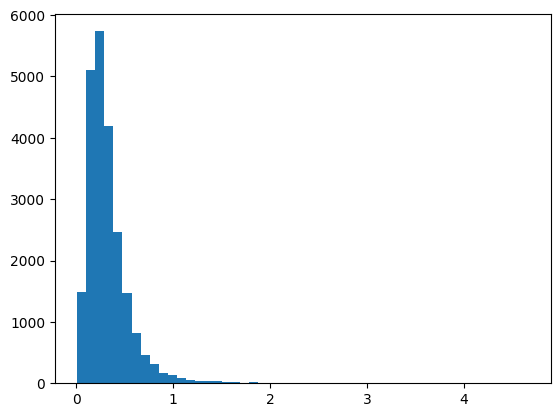

In [10]:
idx = np.where(scenario1_data['y'] == 4)[0]
plt.hist(np.float32(scenario1_data["X"][idx][:,:,0,0]).ravel(), bins=50);

In [3]:
scenario_data = scenario_1_temporal_stacking_classification(
    loader=loader,
    window_size=8,
    max_mask_value=1,
    max_mask_percentage=10.0,
    min_valid_percentage=100.0,  # Changed from 100.0 to 50.0
    orbit='ASC',
    start_date='20200101',
    end_date='20201231',
    scale_type='amplitude',
    skip_optim_offset=False,
)



SCENARIO 1: Temporal Stacking Classification (Dual-Pol)
Parameters:
  - Windows: 8x8
  - Polarization: Dual (HH + HV)
  - Period: 20200101 - 20201231
  - Scale type: amplitude
  - Scale type: amplitude
  - Mask max: 1, 10.0%



Groups:   0%|          | 0/52 [00:00<?, ?grp/s, ABL001 (ABL)]/home/mgallet/Documents/Codes/Python/3_DEVELOPPEMENT/CPAZMAL/script/load_dataset.py:454: RuntimeWarning: invalid value encountered in sqrt
  images_transformed = np.where(images >= 0, np.sqrt(images), np.nan)
Groups: 100%|██████████| 52/52 [00:41<00:00,  1.24grp/s, ROC007 (ROC)]



Results:
  - Total windows: 10288
  - X.shape: (10288, 8, 8, 21, 2)
  - y.shape: (10288,)
  - groups.shape: (10288,)
  - Unique classes: (array([0, 1, 2, 3, 4, 5, 6]), array([4039,  841,  892,   59, 3735,  129,  593]))
  - Unique groups: 44
  - Timestamps per window: min=21, max=21, mean=21.0


In [23]:
# ==========================================================================
# SCÉNARIO 2: Prédiction Temporelle LSTM
# ==========================================================================
scenario2_data = scenario_2_temporal_prediction_lstm(
    loader=loader,
    window_size=32,
    max_mask_value=1,
    max_mask_percentage=10.0,
    orbit='DSC',
    polarization='HH',
    train_start='20200101',
    train_end='20210831',
    predict_start='20210901',
    predict_end='20211231'
)

print(f"\nScénario 2 terminé:")
print(f"  X_train: Liste de {len(scenario2_data['X_train'])} fenêtres")
print(f"  X_predict: Liste de {len(scenario2_data['X_predict'])} fenêtres")
print(f"  Exemple shape X_train[0]: {scenario2_data['X_train'][0].shape}")
print(f"  Exemple shape X_predict[0]: {scenario2_data['X_predict'][0].shape}")
print(f"  Timestamps train[0]: {scenario2_data['timestamps_train'][0]}")
print(f"  Timestamps predict[0]: {scenario2_data['timestamps_predict'][0]}")


SCENARIO 2: Temporal Prediction LSTM
Parameters:
  - Windows: 32x32
  - Polarization: HH
  - Orbit: DSC
  - Train: 20200101 - 20210831
  - Predict: 20210901 - 20211231
  - Scale type: intensity
  - Mask max: 1, 10.0%



Groups: 100%|██████████| 52/52 [00:10<00:00,  4.76grp/s, ROC007 (ROC)]



Results:
  - Total windows: 659
  - X_train.shape: (659, 32, 32, 48)
  - X_predict.shape: (659, 32, 32, 8)
  - groups.shape: (659,)
  - class_labels uniques: (array([0, 1, 2, 3, 4, 5, 6]), array([271,  58,  69,   1, 214,  12,  34]))
  - Unique groups: 35

Scénario 2 terminé:
  X_train: Liste de 659 fenêtres
  X_predict: Liste de 659 fenêtres
  Exemple shape X_train[0]: (32, 32, 48)
  Exemple shape X_predict[0]: (32, 32, 8)
  Timestamps train[0]: ['20200108' '20200130' '20200210' '20200221' '20200303' '20200325'
 '20200405' '20200416' '20200427' '20200508' '20200530' '20200610'
 '20200621' '20200702' '20200713' '20200724' '20200804' '20200815'
 '20200826' '20200906' '20200928' '20201009' '20201020' '20201031'
 '20201111' '20201122' '20201203' '20201214' '20201225' '20210127'
 '20210207' '20210218' '20210301' '20210312' '20210323' '20210403'
 '20210414' '20210425' '20210506' '20210517' '20210528' '20210608'
 '20210619' '20210630' '20210711' '20210722' '20210802' '20210813']
  Timestamps

In [23]:
# ==========================================================================
# SCÉNARIO 3: Domain Adaptation HH vs HV
# ==========================================================================
scenario3_data = scenario_3_domain_adaptation_pol(
    loader=loader,
    window_size=32,
    max_mask_value=1,
    max_mask_percentage=10.0,
    orbit='DSC',
    target_date='20200804'
)

print(f"\nScénario 3 terminé:")
print(f"  X_source (HH) shape: {scenario3_data['X_source'].shape}")
print(f"  X_target (HV) shape: {scenario3_data['X_target'].shape}")
print(f"  Labels: {scenario3_data['y'].shape}")
print(f"  Satellites: {np.unique(scenario3_data['satellites'])}")


SCENARIO 3: Domain Adaptation HH -> HV
Parameters:
  - Windows: 32x32
  - Date: 20200804
  - Orbit: DSC
  - Source: HH -> Target: HV
  - Mask max: 1, 10.0%



Groups: 100%|██████████| 68/68 [00:14<00:00,  4.72grp/s, ROC009 (ROC)]


Results:
  - Total windows: 1217
  - X_source.shape: (1217, 32, 32)
  - X_target.shape: (1217, 32, 32)
  - y.shape: (1217,)
  - groups.shape: (1217,)
  - Unique classes: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([355,  79, 135,   3, 253,  15,   8, 369]))
  - Unique groups: 52

Scénario 3 terminé:
  X_source (HH) shape: (1217, 32, 32)
  X_target (HV) shape: (1217, 32, 32)
  Labels: (1217,)
  Satellites: ['PAZ']


In [24]:
scenario3_data["class_names"]

{0: 'ACC',
 1: 'PLA',
 2: 'ROC',
 3: 'HAG',
 4: 'ABL',
 5: 'ICA',
 6: 'LAC',
 7: 'FOR'}

In [3]:
# ==========================================================================
# SCÉNARIO 4: Domain Adaptation Different Geometries
# ==========================================================================
scenario4_data = scenario_4_domain_adaptation_satellite(
    loader=loader,
    window_size=32,
    max_mask_value=1,
    max_mask_percentage=10.0,
    min_valid_percentage=100.0,
    source_orbit='DSC',
    target_orbit='ASC',
    source_date='20210127',
    target_date='20210214',
    source_polarization='HH',
    target_polarization='HH',
    scale_type='amplitude',
    skip_optim_offset=True
)

# print(f"\nScénario 4 terminé:")
# print(f"  X_source (PAZ)


SCENARIO 4: Domain Adaptation - Different Acquisition Geometries
Parameters:
  - Windows: 32x32
  - Source: PAZ DSC 20210127 HH
  - Target: PAZ ASC 20210214 HH
  - Scale type: amplitude
  - Mask max: 1, 10.0%

Loading SOURCE (DSC 20210127 HH)...


Source Groups:   0%|          | 0/68 [00:00<?, ?grp/s, ABL001 (ABL)]/home/mgallet/Documents/Codes/Python/3_DEVELOPPEMENT/CPAZMAL/script/load_dataset.py:454: RuntimeWarning: invalid value encountered in sqrt
  images_transformed = np.where(images >= 0, np.sqrt(images), np.nan)
Source Groups: 100%|██████████| 68/68 [00:32<00:00,  2.11grp/s, ROC009 (ROC)]



Loading TARGET (ASC 20210214 HH)...


Target Groups: 100%|██████████| 68/68 [00:29<00:00,  2.34grp/s, ROC009 (ROC)]


Results:
  - SOURCE (DSC 20210127 HH):
    X_source.shape: (478, 32, 32)
    y_source.shape: (478,)
    groups_source.shape: (478,)
    Unique classes: (array([0, 1, 2, 4, 7]), array([159,  24,  48, 127, 120]))
    Unique groups: 36
  - TARGET (ASC 20210214 HH):
    X_target.shape: (563, 32, 32)
    y_target.shape: (563,)
    groups_target.shape: (563,)
    Unique groups: 35


In [4]:
np.unique(scenario4_data["y_target"], return_counts=True), np.unique(scenario4_data["groups_target"], return_counts=True)

((array([0, 1, 2, 4, 7]), array([120,  71,  28, 121, 223])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 13, 14, 15, 16, 17, 18,
         19, 20, 21, 22, 23, 24, 51, 52, 53, 54, 55, 56, 58, 59, 61, 62, 64,
         67]),
  array([35,  8, 14,  1,  7,  7, 49, 63, 19, 15,  7,  4,  1, 11,  8,  2, 36,
         46, 17, 23, 80,  9,  2,  4,  5,  2, 26, 27,  6,  1,  1,  1,  3, 17,
          6])))

In [5]:
# Diff of groups
np.setdiff1d(scenario4_data["groups_source"], scenario4_data["groups_target"]),np.setdiff1d(scenario4_data["groups_target"], scenario4_data["groups_source"])


(array([60, 63, 66]), array([54, 55]))